<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/Extra_Trees_Classifier(5labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# =============================================================================
# STEP 1: IMPORT NECESSARY LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support)
import warnings
warnings.filterwarnings('ignore')

print("Step 1: All necessary libraries imported successfully!")
print("Libraries: pandas, numpy, matplotlib, seaborn, sklearn")
print("-" * 60)


Step 1: All necessary libraries imported successfully!
Libraries: pandas, numpy, matplotlib, seaborn, sklearn
------------------------------------------------------------


In [17]:

# =============================================================================
# STEP 2: LOAD THE CSV FILES
# =============================================================================

def load_datasets():
    """Load train, validation, and test datasets"""
    print("\nStep 2: Loading CSV files...")

    try:
        # Load the three CSV files
        train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"✓ Train dataset loaded: {train_df.shape}")
        print(f"✓ Validation dataset loaded: {val_df.shape}")
        print(f"✓ Test dataset loaded: {test_df.shape}")

        # Display basic info about the datasets
        print(f"\nDataset Information:")
        print(f"- Total features: {train_df.shape[1] - 1}")  # -1 for target column
        print(f"- Target column: Production (M.Ton)")
        print(f"- Feature columns: {list(train_df.columns[1:6])}... (and more)")

        return train_df, val_df, test_df

    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")
        return None, None, None

# Load datasets
train_df, val_df, test_df = load_datasets()
print("-" * 60)



Step 2: Loading CSV files...
✓ Train dataset loaded: (3584, 84)
✓ Validation dataset loaded: (768, 84)
✓ Test dataset loaded: (768, 84)

Dataset Information:
- Total features: 83
- Target column: Production (M.Ton)
- Feature columns: ['Area (Acres)', 'Temperature at 2 Meters Range (C) ', 'Year', 'soil_temperature_0_to_7cm(C)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)']... (and more)
------------------------------------------------------------


In [18]:

# =============================================================================
# STEP 3: CREATE QUANTILE-BASED LABELS
# =============================================================================

def create_production_labels(production_values):
    """Convert production values to 5 quantile-based categories"""
    print("\nStep 3: Creating quantile-based labels...")

    # Calculate quantile thresholds (20%, 40%, 60%, 80%)
    quantiles = np.quantile(production_values, [0.2, 0.4, 0.6, 0.8])
    print(f"Quantile thresholds: {quantiles}")

    # Create labels using digitize (0-4 representing Very Low to Very High)
    labels = np.digitize(production_values, quantiles)

    # Define label mapping
    label_mapping = {
        0: 'Very Low',
        1: 'Low',
        2: 'Medium',
        3: 'High',
        4: 'Very High'
    }

    # Display label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nLabel distribution:")
    for label, count in zip(unique, counts):
        print(f"  {label_mapping[label]}: {count} samples")

    return labels, label_mapping

# Create labels for training data to establish quantile thresholds
train_labels, label_mapping = create_production_labels(train_df['Production (M.Ton)'].values)
print("-" * 60)



Step 3: Creating quantile-based labels...
Quantile thresholds: [ 550.2   1447.52  3064.522 6362.6  ]

Label distribution:
  Very Low: 717 samples
  Low: 717 samples
  Medium: 716 samples
  High: 717 samples
  Very High: 717 samples
------------------------------------------------------------


In [19]:

# =============================================================================
# STEP 4: PREPARE FEATURES AND TARGETS
# =============================================================================

def prepare_data(df, quantile_thresholds):
    """Separate features and create labels"""
    print(f"\nStep 4: Preparing data for {df.shape[0]} samples...")

    # Separate target and features
    target_values = df['Production (M.Ton)'].values
    features = df.drop('Production (M.Ton)', axis=1)

    # Create labels using the same quantile thresholds from training data
    labels = np.digitize(target_values, quantile_thresholds)

    print(f"✓ Features shape: {features.shape}")
    print(f"✓ Labels created: {len(labels)} samples")
    print(f"✓ Feature columns: {features.shape[1]} total")

    return features, labels, target_values

# Calculate quantile thresholds from training data
quantile_thresholds = np.quantile(train_df['Production (M.Ton)'].values, [0.2, 0.4, 0.6, 0.8])

# Prepare all datasets
X_train, y_train, prod_train = prepare_data(train_df, quantile_thresholds)
X_val, y_val, prod_val = prepare_data(val_df, quantile_thresholds)
X_test, y_test, prod_test = prepare_data(test_df, quantile_thresholds)

print(f"\nData preparation complete:")
print(f"- Training: {X_train.shape[0]} samples")
print(f"- Validation: {X_val.shape[0]} samples")
print(f"- Testing: {X_test.shape[0]} samples")
print("-" * 60)



Step 4: Preparing data for 3584 samples...
✓ Features shape: (3584, 83)
✓ Labels created: 3584 samples
✓ Feature columns: 83 total

Step 4: Preparing data for 768 samples...
✓ Features shape: (768, 83)
✓ Labels created: 768 samples
✓ Feature columns: 83 total

Step 4: Preparing data for 768 samples...
✓ Features shape: (768, 83)
✓ Labels created: 768 samples
✓ Feature columns: 83 total

Data preparation complete:
- Training: 3584 samples
- Validation: 768 samples
- Testing: 768 samples
------------------------------------------------------------


In [20]:

# =============================================================================
# STEP 5: SCALE THE FEATURES
# =============================================================================

def scale_features(X_train, X_val, X_test):
    """Scale features using StandardScaler"""
    print("\nStep 5: Scaling features...")

    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on training data and transform all datasets
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"✓ Features scaled using StandardScaler")
    print(f"✓ Training features mean: {X_train_scaled.mean():.4f}")
    print(f"✓ Training features std: {X_train_scaled.std():.4f}")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Scale features
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(X_train, X_val, X_test)
print("-" * 60)



Step 5: Scaling features...
✓ Features scaled using StandardScaler
✓ Training features mean: 0.0000
✓ Training features std: 1.0000
------------------------------------------------------------


In [21]:

# =============================================================================
# STEP 6: INITIALIZE EXTRA TREES CLASSIFIER
# =============================================================================

def initialize_model():
    """Initialize Extra Trees Classifier with optimal parameters"""
    print("\nStep 6: Initializing Extra Trees Classifier...")

    # Create model with specific parameters
    model = ExtraTreesClassifier(
        n_estimators=100,          # Number of trees
        random_state=42,           # For reproducibility
        n_jobs=-1,                # Use all CPU cores
        max_depth=None,           # No limit on depth
        min_samples_split=2,      # Minimum samples to split
        min_samples_leaf=1,       # Minimum samples in leaf
        bootstrap=False           # Use all samples for each tree
    )

    print(f"✓ Extra Trees Classifier initialized")
    print(f"✓ Number of estimators: {model.n_estimators}")
    print(f"✓ Random state: {model.random_state}")
    print(f"✓ Using all CPU cores: {model.n_jobs == -1}")

    return model

# Initialize model
model = initialize_model()
print("-" * 60)



Step 6: Initializing Extra Trees Classifier...
✓ Extra Trees Classifier initialized
✓ Number of estimators: 100
✓ Random state: 42
✓ Using all CPU cores: True
------------------------------------------------------------


In [9]:

# =============================================================================
# STEP 7: TRAIN MODEL WITH EPOCH MONITORING
# =============================================================================

def train_with_epochs(model, X_train_scaled, y_train, X_val_scaled, y_val, epochs=10):
    """Train model while monitoring performance over epochs"""
    print(f"\nStep 7: Training model for {epochs} epochs...")

    # Initialize history tracking
    history = {
        'train_accuracy': [],
        'val_accuracy': [],
        'train_f1': [],
        'val_f1': []
    }

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Number of features: {X_train_scaled.shape[1]}")
    print("\nTraining progress:")

    # Train for multiple epochs
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Simulate epoch training by gradually increasing estimators
        current_estimators = max(10, (epoch + 1) * 10)
        model.n_estimators = current_estimators

        # Fit model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        train_pred = model.predict(X_train_scaled)
        val_pred = model.predict(X_val_scaled)

        # Calculate metrics
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)
        train_f1 = f1_score(y_train, train_pred, average='macro')
        val_f1 = f1_score(y_val, val_pred, average='macro')

        # Store history
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print progress
        print(f"  Estimators: {current_estimators}")
        print(f"  Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"  Train F1:  {train_f1:.4f} | Val F1:  {val_f1:.4f}")

    print(f"\n✓ Training completed!")
    print(f"✓ Final number of trees: {model.n_estimators}")

    return model, history

# Train model
trained_model, training_history = train_with_epochs(
    model, X_train_scaled, y_train, X_val_scaled, y_val, epochs=10
)
print("-" * 60)



Step 7: Training model for 10 epochs...
Training samples: 3584
Validation samples: 768
Number of features: 83

Training progress:

Epoch 1/10
  Estimators: 10
  Train Acc: 1.0000 | Val Acc: 0.8398
  Train F1:  1.0000 | Val F1:  0.8386

Epoch 2/10
  Estimators: 20
  Train Acc: 1.0000 | Val Acc: 0.8398
  Train F1:  1.0000 | Val F1:  0.8389

Epoch 3/10
  Estimators: 30
  Train Acc: 1.0000 | Val Acc: 0.8542
  Train F1:  1.0000 | Val F1:  0.8531

Epoch 4/10
  Estimators: 40
  Train Acc: 1.0000 | Val Acc: 0.8594
  Train F1:  1.0000 | Val F1:  0.8581

Epoch 5/10
  Estimators: 50
  Train Acc: 1.0000 | Val Acc: 0.8594
  Train F1:  1.0000 | Val F1:  0.8581

Epoch 6/10
  Estimators: 60
  Train Acc: 1.0000 | Val Acc: 0.8542
  Train F1:  1.0000 | Val F1:  0.8526

Epoch 7/10
  Estimators: 70
  Train Acc: 1.0000 | Val Acc: 0.8581
  Train F1:  1.0000 | Val F1:  0.8567

Epoch 8/10
  Estimators: 80
  Train Acc: 1.0000 | Val Acc: 0.8542
  Train F1:  1.0000 | Val F1:  0.8528

Epoch 9/10
  Estimators: 90



Step 8: Plotting training curves...


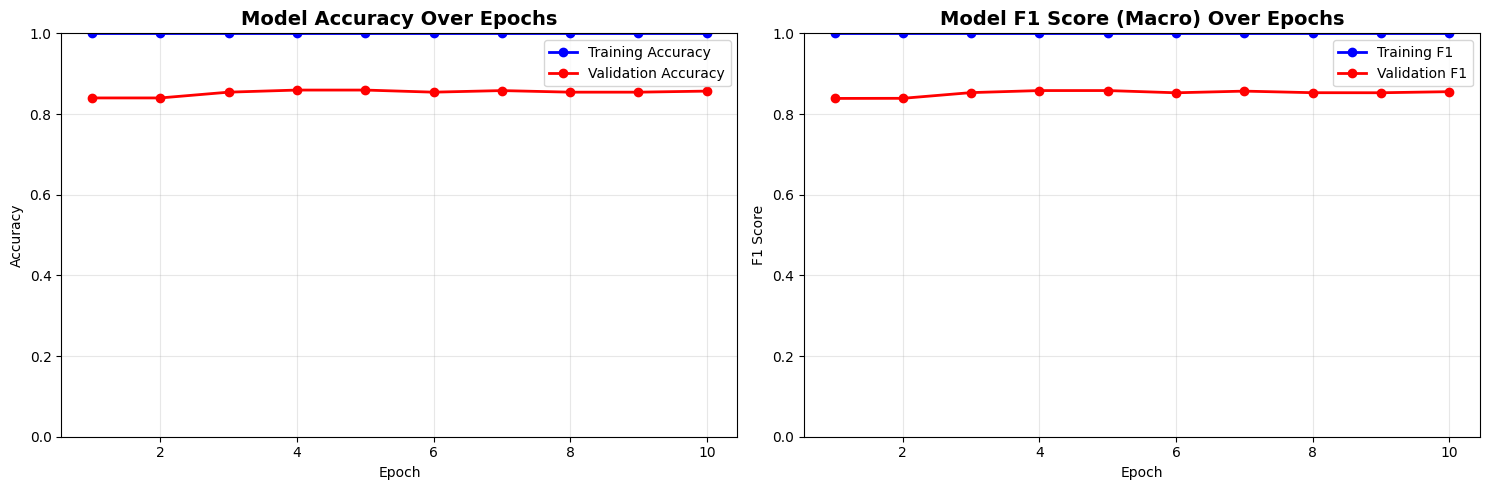

✓ Training curves plotted successfully!
------------------------------------------------------------


In [10]:

# =============================================================================
# STEP 8: PLOT TRAINING HISTORY
# =============================================================================

def plot_training_curves(history):
    """Plot training vs validation accuracy and F1 score"""
    print("\nStep 8: Plotting training curves...")

    epochs = range(1, len(history['train_accuracy']) + 1)

    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(epochs, history['train_accuracy'], 'b-o', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history['val_accuracy'], 'r-o', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Plot F1 score
    ax2.plot(epochs, history['train_f1'], 'b-o', label='Training F1', linewidth=2)
    ax2.plot(epochs, history['val_f1'], 'r-o', label='Validation F1', linewidth=2)
    ax2.set_title('Model F1 Score (Macro) Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print("✓ Training curves plotted successfully!")

# Plot training history
plot_training_curves(training_history)
print("-" * 60)


In [11]:

# =============================================================================
# STEP 9: EVALUATE MODEL ON VALIDATION SET
# =============================================================================

def evaluate_model(model, X_scaled, y_true, dataset_name):
    """Comprehensive model evaluation"""
    print(f"\nStep 9: Evaluating model on {dataset_name} set...")

    # Make predictions
    y_pred = model.predict(X_scaled)

    # Calculate all metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    # Display results
    print(f"\n{dataset_name} Set Evaluation Results:")
    print("=" * 50)
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Precision (Macro):  {precision_macro:.4f}")
    print(f"Recall (Macro):     {recall_macro:.4f}")
    print(f"F1 Score (Macro):   {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    # Per-class breakdown
    print(f"\nPer-Class Metrics:")
    for i in range(len(precision_per_class)):
        class_name = label_mapping[i]
        print(f"  {class_name:<10} - Precision: {precision_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}")

    return {
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

# Evaluate on validation set
val_results = evaluate_model(trained_model, X_val_scaled, y_val, "Validation")
print("-" * 60)


Step 9: Evaluating model on Validation set...

Validation Set Evaluation Results:
Accuracy:           0.8568
Precision (Macro):  0.8561
Recall (Macro):     0.8563
F1 Score (Macro):   0.8554
F1 Score (Weighted): 0.8559

Per-Class Metrics:
  Very Low   - Precision: 0.9441, Recall: 0.9500, F1: 0.9470
  Low        - Precision: 0.8633, Recall: 0.8163, F1: 0.8392
  Medium     - Precision: 0.7962, Recall: 0.8170, F1: 0.8065
  High       - Precision: 0.8276, Recall: 0.7643, F1: 0.7947
  Very High  - Precision: 0.8494, Recall: 0.9338, F1: 0.8896
------------------------------------------------------------



Step 9: Evaluating model on Test set...

Test Set Evaluation Results:
Accuracy:           0.8451
Precision (Macro):  0.8442
Recall (Macro):     0.8422
F1 Score (Macro):   0.8428
F1 Score (Weighted): 0.8447

Per-Class Metrics:
  Very Low   - Precision: 0.8903, Recall: 0.9139, F1: 0.9020
  Low        - Precision: 0.7800, Recall: 0.7748, F1: 0.7774
  Medium     - Precision: 0.7941, Recall: 0.8282, F1: 0.8108
  High       - Precision: 0.8400, Recall: 0.7721, F1: 0.8046
  Very High  - Precision: 0.9167, Recall: 0.9222, F1: 0.9194
------------------------------------------------------------

Step 11: Plotting confusion matrix for Validation set...


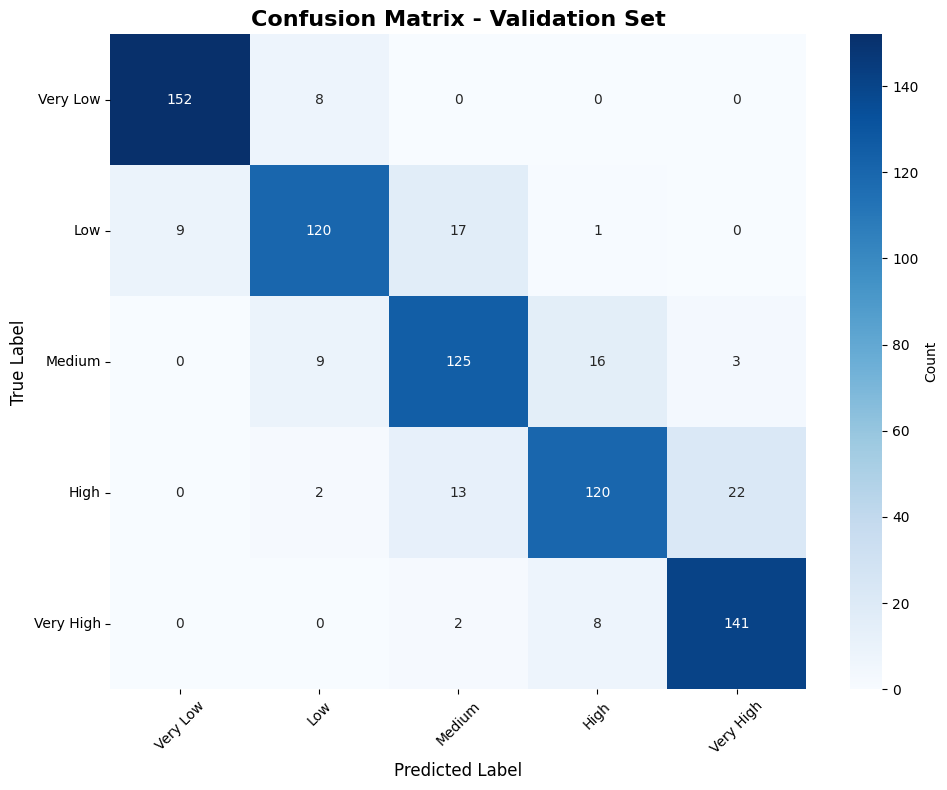

✓ Confusion matrix for Validation set plotted!

Step 11: Plotting confusion matrix for Test set...


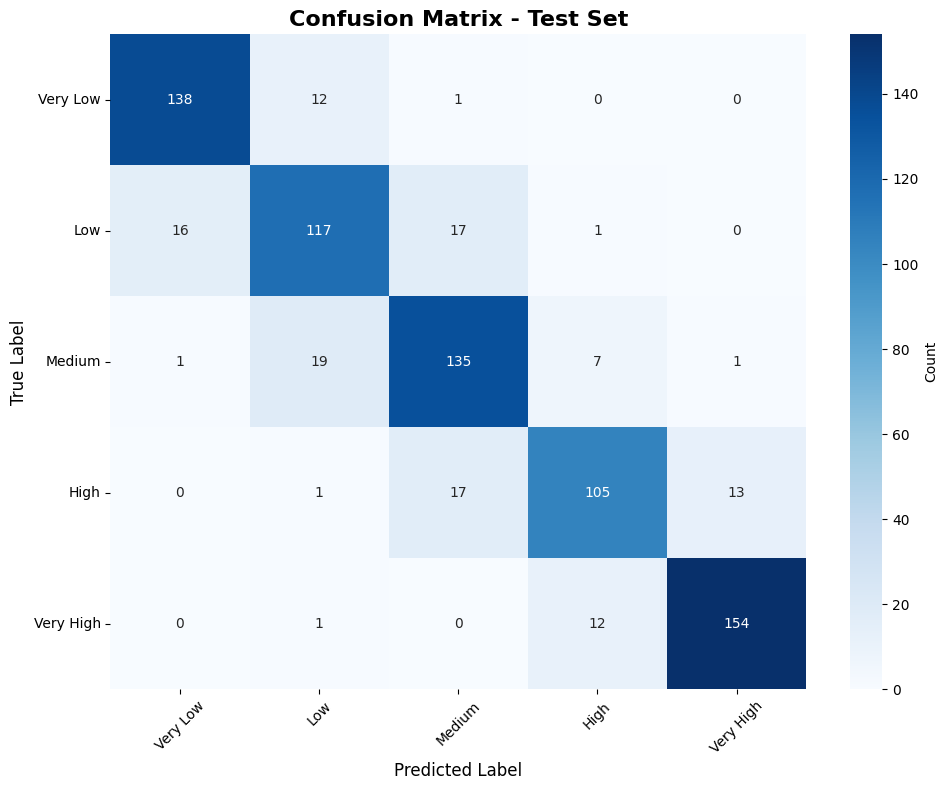

✓ Confusion matrix for Test set plotted!
------------------------------------------------------------


In [12]:


# =============================================================================
# STEP 10: EVALUATE MODEL ON TEST SET
# =============================================================================

# Evaluate on test set
test_results = evaluate_model(trained_model, X_test_scaled, y_test, "Test")
print("-" * 60)

# =============================================================================
# STEP 11: PLOT CONFUSION MATRICES
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, dataset_name, label_mapping):
    """Plot confusion matrix with proper labels"""
    print(f"\nStep 11: Plotting confusion matrix for {dataset_name} set...")

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=[label_mapping[i] for i in range(5)],
               yticklabels=[label_mapping[i] for i in range(5)],
               cbar_kws={'label': 'Count'})

    plt.title(f'Confusion Matrix - {dataset_name} Set', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print(f"✓ Confusion matrix for {dataset_name} set plotted!")

# Plot confusion matrices
plot_confusion_matrix(y_val, val_results['predictions'], "Validation", label_mapping)
plot_confusion_matrix(y_test, test_results['predictions'], "Test", label_mapping)
print("-" * 60)


In [13]:

# =============================================================================
# STEP 12: DISPLAY DETAILED CLASSIFICATION REPORTS
# =============================================================================

def display_classification_reports():
    """Display detailed classification reports"""
    print("\nStep 12: Detailed Classification Reports...")

    class_names = [label_mapping[i] for i in range(5)]

    print("\nVALIDATION SET CLASSIFICATION REPORT:")
    print("=" * 60)
    print(classification_report(y_val, val_results['predictions'],
                              target_names=class_names, digits=4))

    print("\nTEST SET CLASSIFICATION REPORT:")
    print("=" * 60)
    print(classification_report(y_test, test_results['predictions'],
                              target_names=class_names, digits=4))

# Display reports
display_classification_reports()
print("-" * 60)



Step 12: Detailed Classification Reports...

VALIDATION SET CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Very Low     0.9441    0.9500    0.9470       160
         Low     0.8633    0.8163    0.8392       147
      Medium     0.7962    0.8170    0.8065       153
        High     0.8276    0.7643    0.7947       157
   Very High     0.8494    0.9338    0.8896       151

    accuracy                         0.8568       768
   macro avg     0.8561    0.8563    0.8554       768
weighted avg     0.8567    0.8568    0.8559       768


TEST SET CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Very Low     0.8903    0.9139    0.9020       151
         Low     0.7800    0.7748    0.7774       151
      Medium     0.7941    0.8282    0.8108       163
        High     0.8400    0.7721    0.8046       136
   Very High     0.9167    0.9222    0.9194       167

    accuracy                         0.8451       768
   macro avg  


Step 13: Analyzing feature importance...

Top 15 Most Important Features:
--------------------------------------------------
 1. Area (Acres)                        0.164202
 2. Crop_Laushak                        0.056888
 3. Temperature at 2 Meters Range (C)   0.030953
 4. soil_moiture_7_to_28cm(mÂ³/mÂ³)     0.028009
 5. soil_moisture_0_to_7cm(mÂ³/mÂ³)     0.027526
 6. Year                                0.027024
 7. Precipitation Corrected (mm)        0.026859
 8. soil_temperature_0_to_7cm(C)        0.025805
 9. relative_humidity_2m(%)             0.024798
10. Root Zone Soil Wetness (surface to 100 cm below) 0.023568
11. Surface Soil Wetness  (surface to 5 cm below) 0.023143
12. total_rain_mm                       0.022144
13. Crop_Beans                          0.018989
14. Crop_Cabbage                        0.018563
15. Crop_Garlic                         0.017673


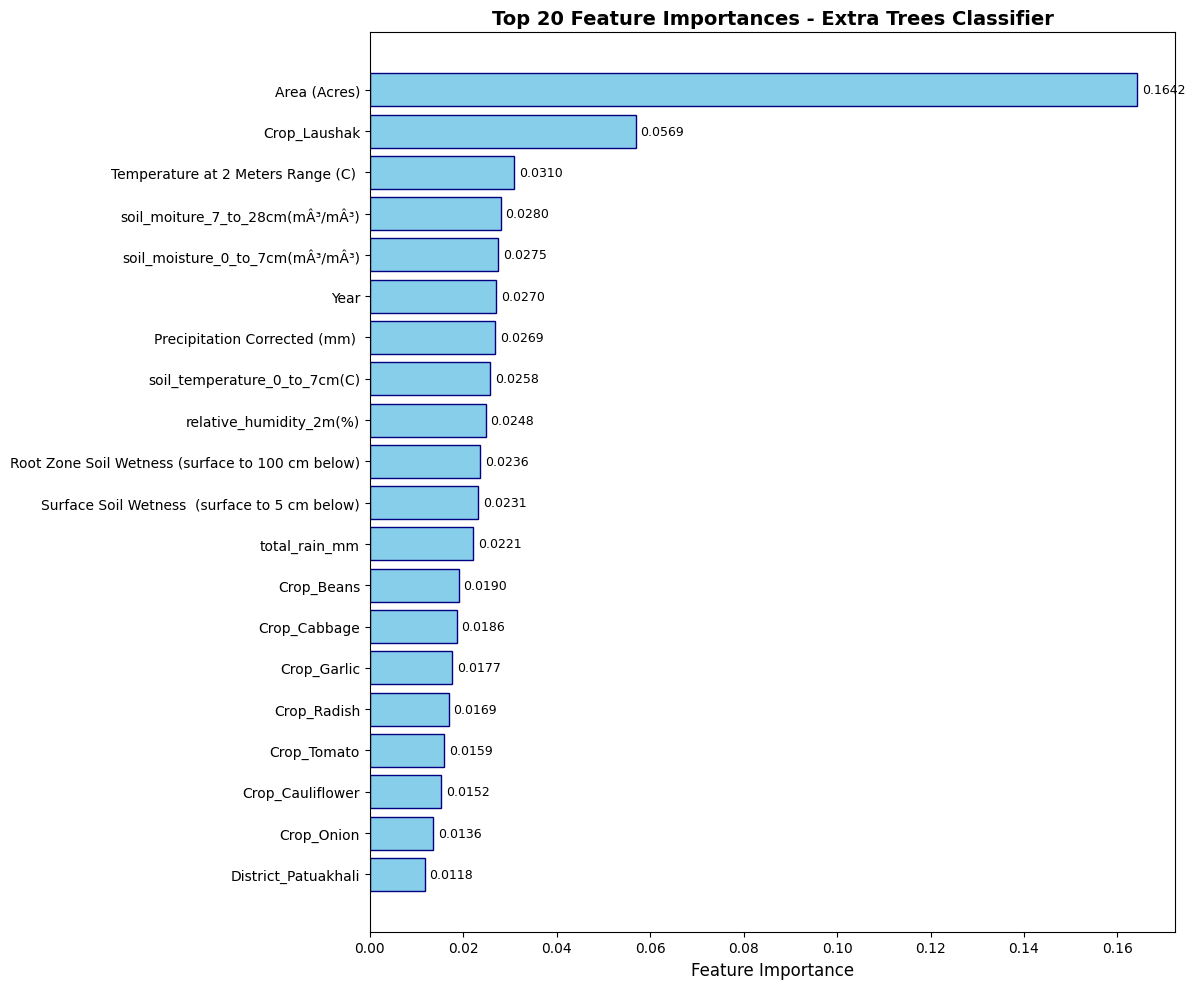

✓ Feature importance analysis completed!
------------------------------------------------------------


In [14]:

# =============================================================================
# STEP 13: ANALYZE FEATURE IMPORTANCE
# =============================================================================

def analyze_feature_importance(model, feature_names):
    """Analyze and display feature importance"""
    print("\nStep 13: Analyzing feature importance...")

    # Get feature importance
    importance = model.feature_importances_

    # Create DataFrame for easier handling
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # Display top features
    print(f"\nTop 15 Most Important Features:")
    print("-" * 50)
    for i, (idx, row) in enumerate(importance_df.head(15).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<35} {row['importance']:.6f}")

    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_20 = importance_df.head(20)

    bars = plt.barh(range(len(top_20)), top_20['importance'], color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Top 20 Feature Importances - Extra Trees Classifier', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("✓ Feature importance analysis completed!")

    return importance_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(trained_model, X_train.columns)
print("-" * 60)


In [15]:

# =============================================================================
# STEP 14: FINAL SUMMARY AND RESULTS
# =============================================================================

def display_final_summary():
    """Display comprehensive final summary"""
    print("\nStep 14: Final Summary and Results")
    print("=" * 80)

    print(f"MODEL CONFIGURATION:")
    print(f"- Algorithm: Extra Trees Classifier")
    print(f"- Number of trees: {trained_model.n_estimators}")
    print(f"- Number of features: {X_train.shape[1]}")
    print(f"- Classification categories: 5 (Very Low to Very High)")
    print(f"- Feature scaling: StandardScaler")

    print(f"\nDATASET SIZES:")
    print(f"- Training samples: {len(X_train)}")
    print(f"- Validation samples: {len(X_val)}")
    print(f"- Test samples: {len(X_test)}")

    print(f"\nVALIDATION SET PERFORMANCE:")
    print(f"- Accuracy: {val_results['accuracy']:.4f}")
    print(f"- Precision (Macro): {val_results['precision_macro']:.4f}")
    print(f"- Recall (Macro): {val_results['recall_macro']:.4f}")
    print(f"- F1 Score (Macro): {val_results['f1_macro']:.4f}")
    print(f"- F1 Score (Weighted): {val_results['f1_weighted']:.4f}")

    print(f"\nTEST SET PERFORMANCE:")
    print(f"- Accuracy: {test_results['accuracy']:.4f}")
    print(f"- Precision (Macro): {test_results['precision_macro']:.4f}")
    print(f"- Recall (Macro): {test_results['recall_macro']:.4f}")
    print(f"- F1 Score (Macro): {test_results['f1_macro']:.4f}")
    print(f"- F1 Score (Weighted): {test_results['f1_weighted']:.4f}")

    print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
    for i, (idx, row) in enumerate(feature_importance_df.head(5).iterrows()):
        print(f"  {i+1}. {row['feature']} (importance: {row['importance']:.6f})")

    print(f"\nMODEL TRAINING SUMMARY:")
    final_train_acc = training_history['train_accuracy'][-1]
    final_val_acc = training_history['val_accuracy'][-1]
    final_train_f1 = training_history['train_f1'][-1]
    final_val_f1 = training_history['val_f1'][-1]

    print(f"- Final Training Accuracy: {final_train_acc:.4f}")
    print(f"- Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"- Final Training F1 (Macro): {final_train_f1:.4f}")
    print(f"- Final Validation F1 (Macro): {final_val_f1:.4f}")

    # Check for overfitting
    overfitting_acc = final_train_acc - final_val_acc
    overfitting_f1 = final_train_f1 - final_val_f1

    print(f"\nOVERFITTING ANALYSIS:")
    print(f"- Accuracy gap (Train - Val): {overfitting_acc:.4f}")
    print(f"- F1 Score gap (Train - Val): {overfitting_f1:.4f}")

    if overfitting_acc > 0.1 or overfitting_f1 > 0.1:
        print("⚠️  Warning: Potential overfitting detected!")
    else:
        print("✓ Model shows good generalization")

    print("=" * 80)
    print("✓ ANALYSIS COMPLETE! All steps executed successfully.")
    print("=" * 80)

# Display final summary
display_final_summary()

# =============================================================================
# ADDITIONAL: SAVE RESULTS (OPTIONAL)
# =============================================================================

def save_results():
    """Save important results to files"""
    print("\nOptional: Saving results to files...")

    try:
        # Save feature importance
        feature_importance_df.to_csv('feature_importance.csv', index=False)
        print("✓ Feature importance saved to 'feature_importance.csv'")

        # Save model predictions
        results_df = pd.DataFrame({
            'validation_true': y_val,
            'validation_pred': val_results['predictions'],
            'test_true': y_test,
            'test_pred': test_results['predictions']
        })
        results_df.to_csv('model_predictions.csv', index=False)
        print("✓ Model predictions saved to 'model_predictions.csv'")

        # Save training history
        history_df = pd.DataFrame(training_history)
        history_df.to_csv('training_history.csv', index=False)
        print("✓ Training history saved to 'training_history.csv'")

    except Exception as e:
        print(f"Note: Could not save files - {e}")

# Uncomment the line below to save results
# save_results()

print("\n🎉 Complete Extra Trees Classification Pipeline Finished! 🎉")


Step 14: Final Summary and Results
MODEL CONFIGURATION:
- Algorithm: Extra Trees Classifier
- Number of trees: 100
- Number of features: 83
- Classification categories: 5 (Very Low to Very High)
- Feature scaling: StandardScaler

DATASET SIZES:
- Training samples: 3584
- Validation samples: 768
- Test samples: 768

VALIDATION SET PERFORMANCE:
- Accuracy: 0.8568
- Precision (Macro): 0.8561
- Recall (Macro): 0.8563
- F1 Score (Macro): 0.8554
- F1 Score (Weighted): 0.8559

TEST SET PERFORMANCE:
- Accuracy: 0.8451
- Precision (Macro): 0.8442
- Recall (Macro): 0.8422
- F1 Score (Macro): 0.8428
- F1 Score (Weighted): 0.8447

TOP 5 MOST IMPORTANT FEATURES:
  1. Area (Acres) (importance: 0.164202)
  2. Crop_Laushak (importance: 0.056888)
  3. Temperature at 2 Meters Range (C)  (importance: 0.030953)
  4. soil_moiture_7_to_28cm(mÂ³/mÂ³) (importance: 0.028009)
  5. soil_moisture_0_to_7cm(mÂ³/mÂ³) (importance: 0.027526)

MODEL TRAINING SUMMARY:
- Final Training Accuracy: 1.0000
- Final Validatio